# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Задача: научиться определять рыночную стоимость объектов недвижимости. Для этого проведем исследовательский анализ данных и установим параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Загрузка файла  и изучение общей информации

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv('/...csv', sep='\t')
pd.set_option('display.max_columns', None)
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


**Выведем основную информацию о датафрейме**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Во многих столбцах есть пропущенные значения, также есть названия столбцов, не в змеином регистре, выделяющиеся на фоне остальных. В датафрейме встречаются все типы данных библиотеки pandas, посмотрим, все ли типы подходят значениям. Размер изначальной таблицы 23699 строк на 22 столбца.

In [4]:
#зафиксируем размер изначальной таблицы
initial_df_count = df.shape[0]

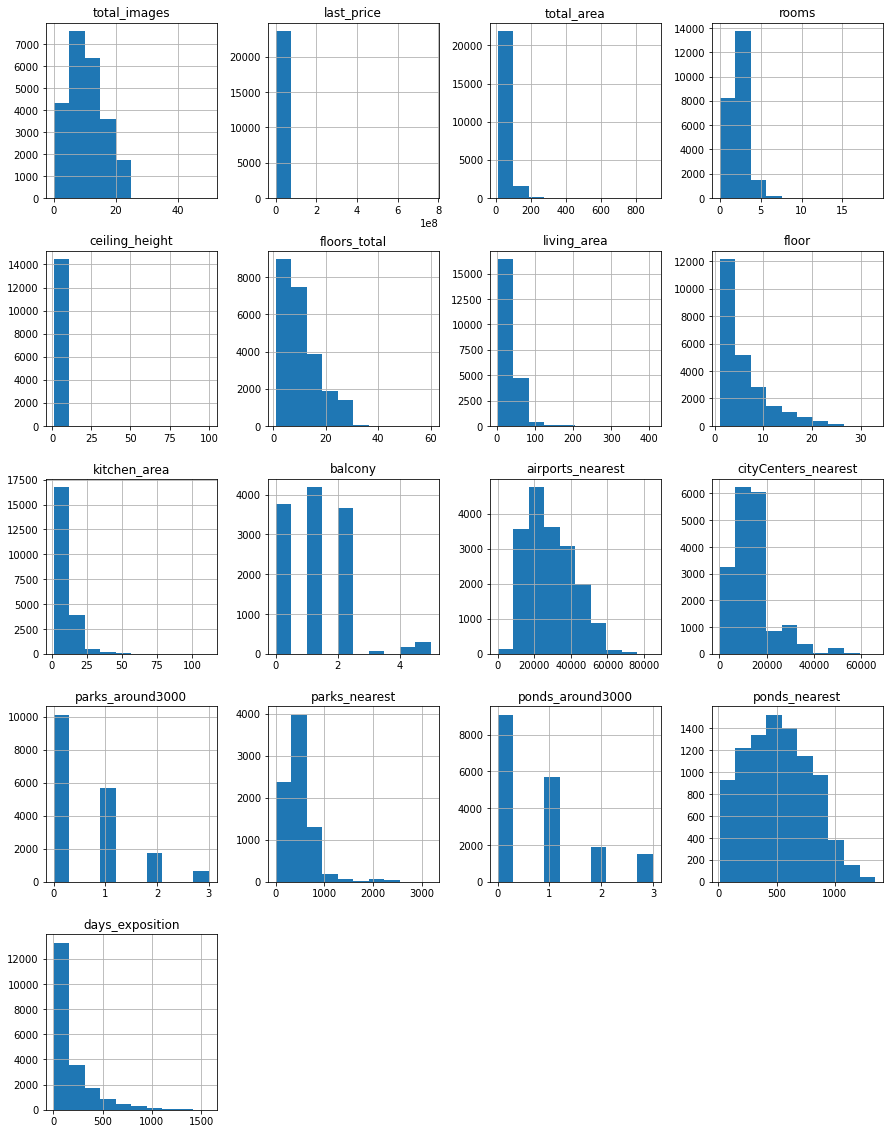

In [5]:
df.hist(figsize=(15, 20))
plt.show()

### Предобработка данных

**Переименуем столбцы в змеиный регистр для удобства**

In [6]:
df = df.rename(columns={'cityCenters_nearest' : 'city_centers_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000': 'ponds_around_3000'})

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

**Выведем количество пропущенных значений для каждого столбца**

In [8]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around_3000        5518
parks_nearest           15620
ponds_around_3000        5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [9]:
df.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


**Посмотрим на дубликаты в названиях**

In [10]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [11]:
#создадим словарь для замены неявных дубликатов
replacement_dict = {
    'городской поселок': 'посёлок',
    'городской посёлок': 'посёлок',
    'поселок городского типа': 'посёлок',
    'посёлок городского типа': 'посёлок',
    'поселок': 'посёлок',
    'посёлок станции': 'посёлок',
    'поселок станции': 'посёлок',
    'посёлок при железнодорожной станции': 'посёлок',
    'поселок при железнодорожной станции': 'посёлок',
    'коттеджный посёлок': 'посёлок'
}

for old_name, new_name in replacement_dict.items():
    df['locality_name'] = df['locality_name'].str.replace(old_name, new_name, regex=False)

In [12]:
df['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'посёлок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'посёлок Металлострой', 'посёлок Лебяжье', 'посёлок Сиверский',
       'посёлок Молодцово', 'посёлок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'посёлок Ефимовский', 'посёлок Плодовое', 'деревня Заклинье',
       'посёлок Торковичи', 'посёлок Первомайское', 'Красное Село',
       'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'посёлок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

In [13]:
#переведем столбец с датой публикации в формат даты (время не указано)
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format = '%Y-%m-%d')

In [14]:
#изменим last_price на тип int для удобства
df['last_price'] = df['last_price'].astype('int')

        floors_total — всего этажей в доме 

Заполним пропущенные значения в floors_total этажем квартиры, пропущенных значений не так много, а это максимально известный нам этаж, также поменяем тип данных на int

In [15]:
df['floors_total'] = df['floors_total'].fillna(df['floor']).astype('int')

        is_apartment - апартаменты (булев тип) - возможно, люди не разбираются, что такое апартаменты, 
    предполагаю, что графу значением "True" заполнили те люди, которые точно уверены в назначении квартиры

In [16]:
#заменим пропущенные значения в is_apartment на False
df['is_apartment'] = df['is_apartment'].fillna(False)

        kitchen_area - площадь кухни в квадратных метрах (м²) - кухня может отсутсвовать, 
        если это квартира-студия, либо если кухня совмещена с гостинной, но мы заполним это значение средним 

In [17]:
#вычисляем среднее отношение площади кухни к общей площади помещения и умножаем его на общую площадь помещения 
df['kitchen_area'].fillna((df['kitchen_area'].mean() / df['total_area'].mean()) * df['total_area'], inplace=True)

        living_area - жилая площадь в квадратных метрах (м²) - возможно, людм не знают, что именно нужно
        включать в "жилую зону" и считают, что полной площади достаточно.

In [18]:
#вычисляем среднее отношение жилой площади к общей площади помещения и умножаем его на общую площадь помещения 
df['living_area'].fillna((df['living_area'].mean() / df['total_area'].mean()) * df['total_area'], inplace=True)

        balcony - число балконов - возможно, пропущенное значение - это отсутсвие балкона

In [19]:
#заменим пропуски в balcony на 0 и изменим тип данных на int
df['balcony'] = df['balcony'].fillna(0).astype('int')

          locality_name - название населённого пункта

In [20]:
#locality_name
df[df['locality_name'].isna()].sort_values(by='city_centers_nearest', ascending=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
16610,11,11940000,112.00,2015-11-19,3,3.00,5,64.000000,2,False,False,False,23.000000,0,NaN,21219.0,1322.0,1.0,740.0,3.0,365.0,319.0
22474,7,24000000,128.00,2015-07-24,4,2.75,6,68.400000,6,False,False,False,16.500000,0,NaN,23297.0,1780.0,3.0,277.0,3.0,561.0,436.0
4189,7,9200000,80.00,2015-12-10,3,4.00,4,52.300000,3,False,False,False,10.400000,0,NaN,21774.0,3039.0,1.0,690.0,1.0,953.0,223.0
19045,6,4650000,48.00,2016-01-25,2,3.12,5,26.200000,1,False,False,False,8.000000,0,NaN,21654.0,3312.0,1.0,549.0,1.0,858.0,254.0
9821,13,8000000,94.50,2015-01-21,4,3.00,2,57.800000,2,False,False,False,11.300000,0,NaN,24953.0,3801.0,1.0,375.0,2.0,532.0,531.0
4151,17,17600000,89.50,2014-12-09,2,3.00,8,39.620000,7,False,False,False,13.380000,0,NaN,25054.0,3902.0,1.0,485.0,3.0,722.0,869.0
8568,10,16000000,155.00,2016-05-09,3,NaN,6,94.000000,3,False,False,False,23.000000,0,NaN,24233.0,4065.0,1.0,547.0,0.0,NaN,248.0
11248,12,6300000,63.10,2015-01-16,4,NaN,8,44.000000,7,False,False,False,8.700000,0,NaN,25221.0,4069.0,0.0,NaN,2.0,653.0,551.0
1097,3,8600000,81.70,2016-04-15,3,3.55,5,50.800000,2,False,False,False,8.800000,0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,147.0
20057,13,11500000,102.00,2015-10-14,2,NaN,5,70.000000,2,False,False,False,17.864862,0,NaN,23478.0,4258.0,0.0,NaN,0.0,NaN,325.0


In [21]:
df.loc[(df['locality_name'].isna()) & (df['city_centers_nearest'] < 14000), 'locality_name'] = 'Санкт-Петербург'
df['locality_name'].isnull().sum()

21

In [22]:
#посмотрим оставшиеся строки (21/49)
df[df['locality_name'].isna()].sort_values(by='city_centers_nearest', ascending=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
5707,7,3700000,30.0,2016-04-29,1,NaN,24,20.000000,23,False,False,False,5.254371,0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0
2603,20,3351765,42.7,2015-09-20,1,NaN,24,15.600000,3,False,False,False,10.700000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593,62.4,2015-10-11,2,NaN,24,33.100000,21,False,False,False,8.200000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
6765,20,4895892,60.7,2015-03-12,2,NaN,24,31.900000,3,False,False,False,12.200000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,468.0
13223,1,2919911,29.4,2015-03-12,1,2.75,24,21.100000,2,False,False,False,5.149284,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,470.0
14273,2,4422000,60.0,2016-03-23,2,2.75,23,32.000000,14,False,False,False,11.900000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,90.0
16499,2,4995573,56.9,2016-06-17,2,NaN,24,29.200000,14,False,False,False,10.900000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,4.0
19972,20,4361004,62.4,2015-09-20,2,NaN,24,33.100000,21,False,False,False,8.200000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,278.0
22933,20,3176015,33.3,2015-04-22,1,NaN,23,15.400000,22,False,False,False,9.000000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,427.0
13690,7,3500000,71.0,2016-06-23,3,2.75,2,45.600000,1,False,False,False,8.000000,2,NaN,20234.0,23659.0,0.0,NaN,2.0,296.0,92.0


In [23]:
#видим много квартир в одном доме, посмотрим, есть ли еще квартиры в этом доме, но с указаной локацией
df.loc[df['airports_nearest'] == 22041.0].head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
237,4,2438033,28.1,2016-11-23,1,NaN,1,20.75,1,False,False,False,4.921594,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,251.0
671,4,6051191,93.6,2017-04-06,3,NaN,8,47.10,8,False,False,False,16.800000,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,123.0
2603,20,3351765,42.7,2015-09-20,1,NaN,24,15.60,3,False,False,False,10.700000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,276.0
2632,2,5130593,62.4,2015-10-11,2,NaN,24,33.10,21,False,False,False,8.200000,0,NaN,22041.0,17369.0,0.0,NaN,1.0,374.0,256.0
2846,4,2325000,27.8,2016-09-21,1,NaN,15,19.40,15,False,False,False,4.869051,0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,307.0


In [24]:
#данные есть, можем смело заполнить 8 пропусков на "Санкт-Петербург"
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 22041.0), 'locality_name'] = 'Санкт-Петербург'
df['locality_name'].isnull().sum()

13

In [25]:
#посмотрим еще раз список оставшихся пропущенных значений
df[df['locality_name'].isna()].sort_values(by='city_centers_nearest', ascending=True)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
5707,7,3700000,30.0,2016-04-29,1,NaN,24,20.000000,23,False,False,False,5.254371,0,NaN,21460.0,16788.0,0.0,NaN,1.0,170.0,49.0
13690,7,3500000,71.0,2016-06-23,3,2.75,2,45.600000,1,False,False,False,8.000000,2,NaN,20234.0,23659.0,0.0,NaN,2.0,296.0,92.0
8986,10,4850000,103.1,2018-07-10,3,NaN,4,68.100000,4,False,False,False,16.700000,0,NaN,19659.0,31813.0,0.0,NaN,0.0,NaN,28.0
21119,8,3500000,43.2,2018-11-11,2,NaN,4,24.666321,2,False,False,False,7.566295,0,NaN,19744.0,31897.0,0.0,NaN,0.0,NaN,9.0
21276,0,17122148,178.3,2017-02-10,1,NaN,3,101.805674,1,False,False,False,41.600000,1,NaN,60195.0,41294.0,0.0,NaN,0.0,NaN,4.0
2033,6,5398000,80.0,2017-05-30,3,NaN,4,42.600000,2,False,False,False,18.600000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
14342,3,3611000,53.5,2017-04-27,1,NaN,4,25.800000,3,False,False,False,9.370295,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0
17535,2,5985000,79.8,2018-07-30,3,NaN,9,45.564177,2,False,False,False,13.976627,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.0
20382,8,1750000,72.9,2018-10-27,3,NaN,5,47.300000,2,False,False,False,8.300000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20590,7,3380000,56.0,2017-11-06,2,2.70,4,29.000000,3,False,False,False,10.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0


In [26]:
#пропусков осталось не так много, можем обработать их путем копирования кода и подстановки значний
df.loc[(df['airports_nearest'] == 21460.0) & (df['city_centers_nearest'] == 16788.0)].head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
48,10,3600000,33.83,2017-10-03,1,NaN,24,15.350000,6,False,False,False,9.500000,0,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,322.0
1565,20,3400000,26.90,2018-10-29,1,NaN,23,15.359353,14,False,False,False,4.711420,1,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,NaN
1656,4,3050000,28.00,2019-02-26,1,NaN,23,20.000000,3,False,False,False,7.000000,0,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,26.0
1784,9,9500000,95.00,2017-12-15,3,NaN,21,54.243068,13,False,False,False,16.638842,0,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,60.0
2563,4,3170000,28.40,2018-07-26,0,NaN,23,20.460000,2,False,True,False,4.974138,2,Санкт-Петербург,21460.0,16788.0,0.0,NaN,1.0,170.0,28.0


In [27]:
#данные и по этому пропуску есть, можем смело заполнить городом "Санкт-Петербург"
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 21460.0), 'locality_name'] = 'Санкт-Петербург'

In [28]:
df.loc[df['airports_nearest'] == 60195.0] #таких строк больше нет, можем посмотреть данные о квартирах рядом

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
21276,0,17122148,178.3,2017-02-10,1,NaN,3,101.805674,1,False,False,False,41.6,1,NaN,60195.0,41294.0,0.0,NaN,0.0,NaN,4.0


In [29]:
df.loc[(df['airports_nearest'] > 50000) & (df['airports_nearest'] < 61000) & (df['city_centers_nearest'] > 35000) & (df['city_centers_nearest'] < 42000)] 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
146,11,4400000,53.6,2018-03-31,2,2.55,10,29.200000,10,False,False,False,7.800000,1,Сестрорецк,60883.0,36102.0,1.0,341.0,2.0,256.0,55.0
165,17,7430000,60.2,2019-02-28,2,2.50,4,34.372976,2,False,False,False,10.200000,0,Сестрорецк,54526.0,35625.0,0.0,NaN,0.0,NaN,NaN
331,12,7500000,124.8,2018-04-25,2,NaN,4,37.100000,1,False,False,False,14.100000,0,Сестрорецк,54164.0,35263.0,0.0,NaN,0.0,NaN,NaN
1036,6,4700000,68.0,2017-12-25,2,3.00,4,38.826617,1,False,False,False,11.909908,0,Сестрорецк,54175.0,35275.0,0.0,NaN,0.0,NaN,60.0
1434,4,4950000,56.0,2018-09-26,3,2.50,5,41.000000,2,False,False,False,5.400000,0,Сестрорецк,58223.0,35152.0,1.0,531.0,2.0,192.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22233,11,3850000,40.0,2015-11-09,1,NaN,5,18.000000,2,False,False,False,7.005828,2,Сестрорецк,54328.0,35334.0,0.0,NaN,0.0,NaN,647.0
22257,5,5490000,61.0,2017-11-14,3,NaN,5,41.000000,4,False,False,False,7.500000,0,Сестрорецк,59705.0,36635.0,1.0,298.0,2.0,325.0,200.0
22363,4,5000000,55.0,2017-09-13,1,NaN,4,25.000000,2,False,False,False,17.000000,2,Сестрорецк,53952.0,35051.0,0.0,NaN,0.0,NaN,71.0
22550,2,5800000,115.0,2017-09-12,2,NaN,1,40.000000,1,False,False,False,14.000000,0,Сестрорецк,54331.0,35394.0,0.0,NaN,0.0,NaN,124.0


In [30]:
#исходя их похожих по удаленности от центра и аэропорта квартир можем заполнить наш пропуск городом "Сестрорецк"
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 60195.0), 'locality_name'] = 'Сестрорецк'

In [31]:
df.loc[df['airports_nearest'] == 20234.0]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
13690,7,3500000,71.0,2016-06-23,3,2.75,2,45.6,1,False,False,False,8.0,2,NaN,20234.0,23659.0,0.0,NaN,2.0,296.0,92.0


In [32]:
df.loc[(df['airports_nearest'] > 20000) & (df['airports_nearest'] < 21000) & (df['city_centers_nearest'] > 23000) & (df['city_centers_nearest'] < 24000)] 

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
13690,7,3500000,71.0,2016-06-23,3,2.75,2,45.6,1,False,False,False,8.0,2,NaN,20234.0,23659.0,0.0,NaN,2.0,296.0,92.0
21733,6,3250000,31.0,2016-05-31,1,NaN,5,17.0,4,False,False,False,5.0,0,Санкт-Петербург,20243.0,23668.0,0.0,NaN,1.0,1069.0,246.0


In [33]:
#исходя их удаленности от центра и аэропорта можем заполнить этот пропуск городом "Санкт-Петербург"
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 20234.0), 'locality_name'] = 'Санкт-Петербург'

In [34]:
df.query('locality_name == "Пушкин"').sort_values(by='city_centers_nearest')
#похоже на наши пропуски, но рядом есть Павловск, посмотрим и этот срез

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
2354,1,3500000,36.8,2017-11-02,1,2.50,9,18.6,5,False,False,False,7.5,1,Пушкин,12157.0,24311.0,1.0,94.0,1.0,1025.0,130.0
21640,18,3500000,35.2,2017-01-24,1,NaN,5,14.0,3,False,False,False,7.7,1,Пушкин,12383.0,24537.0,1.0,630.0,0.0,NaN,56.0
20813,3,6200000,72.5,2017-07-20,3,NaN,6,41.0,2,False,False,False,7.5,2,Пушкин,12391.0,24545.0,1.0,122.0,1.0,565.0,58.0
5167,19,9973000,88.0,2017-12-21,3,2.80,4,50.0,3,False,False,False,15.0,0,Пушкин,12489.0,24643.0,1.0,690.0,0.0,NaN,7.0
6644,15,3899000,38.0,2017-04-27,1,NaN,4,18.0,1,False,False,False,10.0,0,Пушкин,12489.0,24643.0,1.0,690.0,0.0,NaN,67.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,20,6300000,78.8,2016-04-16,3,2.64,4,43.3,2,False,False,False,13.3,0,Пушкин,19919.0,34773.0,0.0,NaN,2.0,694.0,66.0
22392,20,4050000,38.0,2019-02-10,1,2.60,4,20.1,3,False,False,False,10.0,1,Пушкин,20109.0,34964.0,1.0,724.0,3.0,531.0,23.0
5589,7,3150000,44.7,2017-08-22,2,2.54,5,31.4,1,False,False,False,5.4,0,Пушкин,21038.0,35610.0,0.0,NaN,0.0,NaN,308.0
17821,10,1990000,31.2,2017-07-11,1,NaN,5,17.4,4,False,False,False,5.5,0,Пушкин,21038.0,35610.0,0.0,NaN,0.0,NaN,218.0


In [35]:
df.query('locality_name == "Павловск"').sort_values(by='city_centers_nearest')
#видим, что пропуски с удаленностью от аэропорта 19659.0, 19744.0, от центра 31813.0, 31897.0 соответсвуют Павловску
#т.к. у квартир с такой же удаленностью от аэропорта, которые находятся в Пушкине, большая удаленность от центра

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
14442,14,5100000,55.3,2017-09-11,2,NaN,3,35.000000,2,False,False,False,8.200000,0,Павловск,19380.0,31533.0,1.0,522.0,1.0,639.0,134.0
14278,10,5500000,57.5,2018-10-02,2,3.00,3,33.000000,1,False,False,False,8.000000,0,Павловск,19380.0,31533.0,1.0,522.0,1.0,639.0,121.0
19872,14,3600000,43.7,2017-01-24,2,2.50,4,28.200000,1,False,False,False,5.100000,0,Павловск,19446.0,31600.0,2.0,684.0,1.0,799.0,NaN
284,6,2650000,30.5,2018-02-06,1,2.60,4,17.200000,2,False,False,False,5.000000,1,Павловск,19516.0,31670.0,2.0,314.0,1.0,627.0,37.0
8732,20,9300000,151.5,2017-06-27,4,3.00,3,57.100000,1,False,False,False,7.700000,0,Павловск,19575.0,31729.0,2.0,292.0,1.0,605.0,513.0
221,10,3750000,43.0,2018-05-09,2,NaN,4,28.000000,1,False,False,False,6.000000,0,Павловск,19775.0,31929.0,2.0,651.0,1.0,1064.0,277.0
19240,7,2700000,31.5,2018-02-08,1,NaN,4,18.000000,4,False,False,False,5.300000,0,Павловск,19991.0,32145.0,3.0,395.0,2.0,904.0,175.0
20448,18,4790000,54.5,2019-02-26,2,2.50,4,33.300000,4,False,False,False,8.100000,0,Павловск,20016.0,32169.0,2.0,596.0,1.0,1001.0,3.0
14304,6,2690000,31.0,2015-11-23,1,2.50,4,17.700000,1,False,False,False,5.500000,0,Павловск,20063.0,32217.0,2.0,570.0,0.0,NaN,298.0
13513,11,3650000,35.5,2017-11-09,1,2.50,5,17.400000,3,False,False,False,9.600000,0,Павловск,20126.0,32279.0,0.0,NaN,0.0,NaN,177.0


In [36]:
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 19659.0), 'locality_name'] = 'Павловск'
df.loc[(df['locality_name'].isna()) & (df['airports_nearest'] == 19744.0), 'locality_name'] = 'Павловск'

In [37]:
df[df['locality_name'].isna()]
#видим, что остались строки, в которых слишком много пропусков в данных, удалим эти 8 строк

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
2033,6,5398000,80.0,2017-05-30,3,NaN,4,42.600000,2,False,False,False,18.600000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.0
14342,3,3611000,53.5,2017-04-27,1,NaN,4,25.800000,3,False,False,False,9.370295,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.0
17535,2,5985000,79.8,2018-07-30,3,NaN,9,45.564177,2,False,False,False,13.976627,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,213.0
20382,8,1750000,72.9,2018-10-27,3,NaN,5,47.300000,2,False,False,False,8.300000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20590,7,3380000,56.0,2017-11-06,2,2.7,4,29.000000,3,False,False,False,10.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0
21715,2,6047550,80.1,2018-07-30,2,NaN,9,30.500000,2,False,False,False,29.200000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,176.0
21898,2,5886750,83.5,2018-07-30,2,NaN,9,36.600000,2,False,False,False,29.700000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0
22717,9,3000000,35.0,2018-01-02,1,2.6,16,16.000000,7,False,False,False,10.000000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.0


In [38]:
df = df.dropna(subset=['locality_name'])

        city_centers_nearest

Посмотрим, что мы можем сделать с этими данными. Попробуем посмотреть на среднее значение до центра в каждом городе. 

In [39]:
unique_localities = df['locality_name'].unique()

#проходим по каждому городу
for locality in unique_localities:
    #вычисляем среднее значение расстояния до центра для текущего города
    mean_distance = df.loc[(df['locality_name'] == locality) & (~df['city_centers_nearest'].isna()), 'city_centers_nearest'].mean()
    
    #выводим среднее значение для текущего города, чтобы посмотреть на качество заполнения
    print(f"Среднее значение {locality}: {mean_distance}")
    
    #ваполняем пропущенные значения, где это возможно, средним для города
df.loc[(df['locality_name'] == locality) & (df['city_centers_nearest'].isna()), 'city_centers_nearest'] = mean_distance

Среднее значение Санкт-Петербург: 11595.977640463754
Среднее значение посёлок Шушары: 24243.3876146789
Среднее значение посёлок Янино-1: nan
Среднее значение посёлок Парголово: 19924.776758409786
Среднее значение посёлок Мурино: 21888.0
Среднее значение Ломоносов: 50739.969696969696
Среднее значение Сертолово: nan
Среднее значение Петергоф: 35468.92537313433
Среднее значение Пушкин: 28745.375
Среднее значение деревня Кудрово: nan
Среднее значение Коммунар: nan
Среднее значение Колпино: 32113.771513353116
Среднее значение посёлок Красный Бор: nan
Среднее значение Гатчина: nan
Среднее значение деревня Фёдоровское: nan
Среднее значение Выборг: nan
Среднее значение Кронштадт: 49195.72631578947
Среднее значение Кировск: nan
Среднее значение деревня Новое Девяткино: nan
Среднее значение посёлок Металлострой: 27561.348484848484
Среднее значение посёлок Лебяжье: nan
Среднее значение посёлок Сиверский: nan
Среднее значение посёлок Молодцово: nan
Среднее значение посёлок Кузьмоловский: nan
Средн

        Видим, что в большинстве городов нет данных для подсчета среднего, 
        значит, остальные данные оставляем как есть, то же с airports_nearest

In [40]:
unique_localities = df['locality_name'].unique()

#проходим по каждому городу
for locality in unique_localities:
    #вычисляем среднее значение расстояния до аэропорта для текущего города
    mean_distance = df.loc[(df['locality_name'] == locality) & (~df['airports_nearest'].isna()), 'airports_nearest'].mean()

    #заполняем пропущенные значения средним для текущего города
    df.loc[(df['locality_name'] == locality) & (df['airports_nearest'].isna()), 'airports_nearest'] = mean_distance

In [41]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9189
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4864
city_centers_nearest     5511
parks_around_3000        5510
parks_nearest           15612
ponds_around_3000        5510
ponds_nearest           14581
days_exposition          3180
dtype: int64

        ceiling_height — высота потолков (м)

In [42]:
df.sort_values(by='ceiling_height', ascending=False).head(50)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
22869,0,15000000,25.0,2018-07-25,1,100.00,5,14.000000,5,True,False,False,11.000000,5,Санкт-Петербург,34963.000000,8283.0,1.0,223.0,3.0,30.0,19.0
3148,14,2900000,75.0,2018-11-12,3,32.00,3,53.000000,2,False,False,False,8.000000,0,Волхов,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22336,19,9999000,92.4,2019-04-05,2,32.00,6,55.500000,5,False,False,False,16.500000,4,Санкт-Петербург,18838.000000,3506.0,0.0,NaN,3.0,511.0,NaN
21377,19,4900000,42.0,2017-04-18,1,27.50,24,37.700000,19,False,False,False,11.000000,2,Санкт-Петербург,42742.000000,9760.0,0.0,NaN,0.0,NaN,61.0
21824,20,2450000,44.0,2019-02-12,2,27.00,2,38.000000,2,False,False,False,8.600000,2,посёлок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20478,11,8000000,45.0,2017-07-18,1,27.00,4,22.000000,2,False,False,False,10.000000,1,Санкт-Петербург,18975.000000,3246.0,0.0,NaN,3.0,449.0,429.0
17857,1,3900000,56.0,2017-12-22,3,27.00,5,33.000000,4,False,False,False,9.808160,0,Санкт-Петербург,41030.000000,15543.0,0.0,NaN,0.0,NaN,73.0
10773,8,3800000,58.0,2017-10-13,2,27.00,10,30.100000,3,False,False,False,8.100000,2,посёлок Мурино,51553.000000,NaN,NaN,NaN,NaN,NaN,71.0
5246,0,2500000,54.0,2017-10-13,2,27.00,5,30.000000,3,False,False,False,9.000000,2,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0
5807,17,8150000,80.0,2019-01-09,2,27.00,36,41.000000,13,False,False,False,12.000000,5,Санкт-Петербург,18732.000000,20444.0,0.0,NaN,3.0,80.0,38.0


Прежде чем заполнять пропуски, удалим значения, которые заполнены неверно. В строке со значением 100 удалим значение и поставим "NaN". В строках со значениями 32-24 скорее всего данные записаны неверно на один десяток. В строках со значениями 22.6-8 тоже изменим значение на "NaN". От 6 метров высота потолков реальна, ведь бывают двухуровневые квартиры.

In [43]:
#замена значения 100 на NaN
df['ceiling_height'].replace(100, np.nan, inplace=True)

#замена значений в диапазоне 24-32
df.loc[(df['ceiling_height'] >= 24) & (df['ceiling_height'] <= 32), 'ceiling_height'] /= 10

#замена значений в диапазоне 8-22.6 на NaN
df['ceiling_height'] = df['ceiling_height'].where(~df['ceiling_height'].between(8, 22.60), np.nan)


In [44]:
df.sort_values(by='ceiling_height', ascending=False).head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
20264,17,119000000,187.6,2017-07-10,4,6.0,7,147.000000,7,False,False,False,15.600000,0,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0
21227,0,8200000,71.0,2017-07-21,0,5.8,5,68.000000,5,False,True,False,12.435345,0,Санкт-Петербург,20170.0,1261.0,2.0,295.0,3.0,366.0,30.0
1388,20,59800000,399.0,2015-01-21,5,5.6,6,227.820886,6,False,False,False,69.883137,0,Санкт-Петербург,26204.0,6934.0,2.0,149.0,2.0,577.0,719.0
7578,17,38000000,143.0,2017-11-02,3,5.5,5,83.000000,5,False,False,False,29.000000,1,Санкт-Петербург,26333.0,6448.0,3.0,479.0,0.0,NaN,NaN
12628,14,3900000,50.0,2018-03-29,1,5.3,5,28.548983,5,False,False,False,8.757285,0,Санкт-Петербург,19644.0,3918.0,1.0,505.0,1.0,92.0,8.0


    Так как в Санкт-Петербурге в центре города в основном старый фонд - дома с высокими потолками. А на окраинах 
    в основном многоэтажные новостройки, в которых потолков под 3 метра не бывает, логичнее сгруппировать дома 
    по расположению и уже потом заполнять медианным или средним значением. 
    Категоризируем все строки по удаленности от центра и возьмем среднее по высоте потолков:
        0-2 км от центра (категория 'центр')
        2-5 км от центра (категория 'близко к центру')
        5-17 км от центра (категория 'в пределах города')
        другие города(категория 'область')
        
    Высота потолков, например, в Кудрово и Пушкине отличается, поскольку один город состоит полностью из новостроек, другой нет, поэтому сначала заполним высоту потолков средним значением по пригороду, а потом оставшиеся поропуски заполним средней высотой потолков по области 

In [45]:
df['ceiling_height'].isnull().sum()

9198

In [46]:
#удаляем пропуски в city_centers_nearest, где указан "Санкт-Петербург"
#их немного и корректно заполнить высоту потолков не имея локацию мы не сможем
df.drop(df[(df['locality_name'] == 'Санкт-Петербург') & (df['city_centers_nearest'].isna())].index, inplace=True)

In [47]:
#посмотрим количество оставшихся пропусков
df['ceiling_height'].isnull().sum()

9168

In [48]:
#получим уникальные значения городов, исключая Санкт-Петербург
unique_localities = df['locality_name'].unique()
unique_localities = np.setdiff1d(unique_localities, 'Санкт-Петербург')

#посчитаем среднее по каждому городу, кроме Санкт-Петербурга
for locality in unique_localities:
    mean_ceiling_height = df.loc[(df['locality_name'] == locality) & (~df['ceiling_height'].isna()), 'ceiling_height'].mean()
    
    #заполняем пропущенные значения для текущего города
    df.loc[(df['locality_name'] == locality) & (df['ceiling_height'].isna()), 'ceiling_height'] = mean_ceiling_height

In [49]:
#посмотрим количество оставшихся пропусков
df['ceiling_height'].isnull().sum()

5719

In [50]:
#посмотрим количество оставшихся пропусков с городом "Санкт-Петербург"
df[df['locality_name'] == 'Санкт-Петербург']['ceiling_height'].isnull().sum()

5620

In [51]:
#напишем функцию для категорий
def group_center(row):
    if row['locality_name'] == 'Санкт-Петербург':
        if row['city_centers_nearest'] < 2500:
            return 'центр'
        elif row['city_centers_nearest'] < 5000:
            return 'близко к центру'
        elif row['city_centers_nearest'] > 5000:
            return 'в пределах города'
    else:
        return 'область'

#применяем функцию для всех строк
df['fromcenter_category'] = df.apply(group_center, axis=1)
df.head(10)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,fromcenter_category
0,20,13000000,108.00,2019-03-07,3,2.700000,16,51.000000,8,False,False,False,25.000000,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,в пределах города
1,7,3350000,40.40,2018-12-04,1,2.644470,11,18.600000,1,False,False,False,11.000000,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,область
2,10,5196000,56.00,2015-08-20,2,NaN,5,34.300000,4,False,False,False,8.300000,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,в пределах города
3,0,64900000,159.00,2015-07-24,3,NaN,14,90.785766,9,False,False,False,27.848168,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,в пределах города
4,2,10000000,100.00,2018-06-19,2,3.030000,14,32.000000,13,False,False,False,41.000000,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,в пределах города
5,10,2890000,30.40,2018-09-10,1,2.632759,12,14.400000,5,False,False,False,9.100000,0,посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,область
6,6,3700000,37.30,2017-11-02,1,2.630292,26,10.600000,6,False,False,False,14.400000,1,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,область
7,5,7915000,71.60,2019-04-18,2,NaN,24,40.882144,22,False,False,False,18.900000,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,в пределах города
8,20,2900000,33.16,2018-05-23,1,2.695280,27,15.430000,26,False,False,False,8.810000,0,посёлок Мурино,51553.0,NaN,NaN,NaN,NaN,NaN,189.0,область
9,18,5400000,61.00,2017-02-26,3,2.500000,9,43.600000,7,False,False,False,6.500000,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,в пределах города


In [52]:
#вычисляем среднее значение высоты потолков для строк, где fromcenter_category равно "область"
mean_ceiling_height = df.loc[df['fromcenter_category'] == 'область', 'ceiling_height'].mean()

#заполняем пропущенные значения в столбце ceiling_height средним значением
df.loc[df['fromcenter_category'] == 'область', 'ceiling_height'] = df.loc[df['fromcenter_category'] == 'область', 'ceiling_height'].fillna(mean_ceiling_height)

In [53]:
#проверяем, что в оставшихся пропусках в ceiling_height в столбце locality только "Санкт-Петербург"
df[(df['ceiling_height'].isna()) & (df['locality_name'] != 'Санкт-Петербург')]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,fromcenter_category


In [54]:
#вычисляем среднее значение по группам и сортируем
df.groupby('fromcenter_category')['ceiling_height'].mean().sort_values(ascending=False)

fromcenter_category
центр                3.239759
близко к центру      3.136863
в пределах города    2.699301
область              2.644348
Name: ceiling_height, dtype: float64

In [55]:
df['ceiling_height'].isnull().sum()

5620

In [56]:
#функция для заполнения пропущенных значений средним значением группы
def fill_na_with_mean(group):
    return group.fillna(group.mean())

#заполненяем пропущенные значения столбца ceiling_height
df['ceiling_height'] = df.groupby('fromcenter_category')['ceiling_height'].apply(fill_na_with_mean)

In [57]:
#в parks_around_3000 в пропусках ставим 0 и меняем тип данных
df['parks_around_3000'] = df['parks_around_3000'].fillna(value=0).astype(int)

In [58]:
#в ponds_around_3000 в пропусках ставим 0 и меняем тип данных
df['ponds_around_3000'] = df['ponds_around_3000'].fillna(value=0).astype(int)

In [59]:
#заменим заменим тип данных в days_exposition
df['days_exposition'] = np.floor(pd.to_numeric(df['days_exposition'], errors='coerce')).astype('Int64')

In [60]:
df.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4864
city_centers_nearest     5450
parks_around_3000           0
parks_nearest           15551
ponds_around_3000           0
ponds_nearest           14520
days_exposition          3144
fromcenter_category         0
dtype: int64

In [61]:
#проверим типы данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23630 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23630 non-null  int64         
 1   last_price            23630 non-null  int64         
 2   total_area            23630 non-null  float64       
 3   first_day_exposition  23630 non-null  datetime64[ns]
 4   rooms                 23630 non-null  int64         
 5   ceiling_height        23630 non-null  float64       
 6   floors_total          23630 non-null  int64         
 7   living_area           23630 non-null  float64       
 8   floor                 23630 non-null  int64         
 9   is_apartment          23630 non-null  bool          
 10  studio                23630 non-null  bool          
 11  open_plan             23630 non-null  bool          
 12  kitchen_area          23630 non-null  float64       
 13  balcony         

### Добавим в таблицу новые столбцы

    Цена одного квадратного метра

In [62]:
#вычисляем цену одного квадратного метра и округляем до двух знаков после запятой
df['price_square_meter'] = (df['last_price'] / df['total_area']).round(2)

    День недели публикации объявления (0 — понедельник, 1 — вторник и так далее);

In [63]:
#добавляем столбцы дня недели, месяца и года
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

    Тип этажа квартиры

In [64]:
#создаём функцию для заполнения столбца с типом этажа
def floor_group(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
df['floor_type'] = df.apply(floor_group, axis=1)

    Расстояние до центра города в километрах

In [65]:
df['city_centers_nearest_km'] = (df['city_centers_nearest'] / 1000).round()

In [66]:
# Создание нового столбца 'last_price_m' в миллионах
df['last_price_m'] = (df['last_price'] / 1_000_000).round(3)

### Проведение исследовательского анализ данных

,total_area
count,23630.000000
mean,60.272968
std,35.490899
min,12.000000
25%,40.000000
50%,52.000000
75%,69.700000
max,900.000000


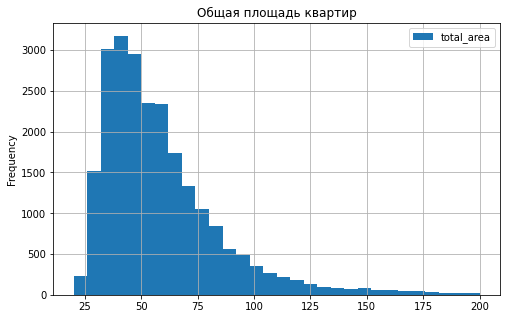

In [67]:
#изучим общую площадь
df.plot(y='total_area', kind='hist', bins=30, grid=True, figsize=(8,5), range=(20,200), title='Oбщая площадь квартир')
df['total_area'].describe().to_frame()

Большая часть квартир имеет метраж от 30 до 90 кв.м. Максимальная площадь квартиры - 900 кв.м, это может быть целый этаж, либо частный дом. Минимальная площадь квартиры - 12 кв.м., вероятнее, это квартира-студия, любо комната в коммуналке. 

In [68]:
#удалим аномальные значения
df = df.query('total_area < 300')

,living_area
count,23569.000000
mean,34.056895
std,19.721820
min,2.000000
25%,19.000000
50%,30.000000
75%,42.000000
max,250.000000


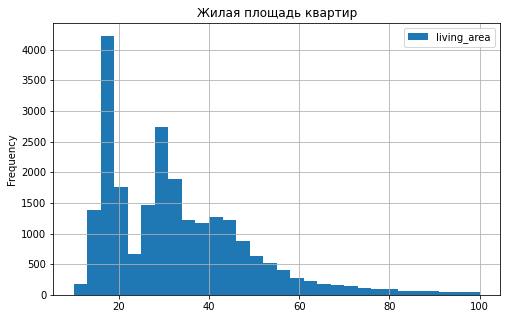

In [69]:
#изучим жилую площадь
df.plot(y='living_area', kind='hist', bins=30, grid=True, figsize=(8,5), range=(10,100), title='Жилая площадь квартир')
df['living_area'].describe().to_frame()

Наиболее часто встречаются квартиры с жилой площадью от 10 до 50 метров. Площадь более 80 метров встречаются редко. Два пика на графике, вероятно, объясняются тем, что они соответствуют площадям квартир с разными количествами комнат.

,kitchen_area
count,23569.000000
mean,10.403184
std,5.650117
min,1.300000
25%,7.000000
50%,9.000000
75%,12.000000
max,107.000000


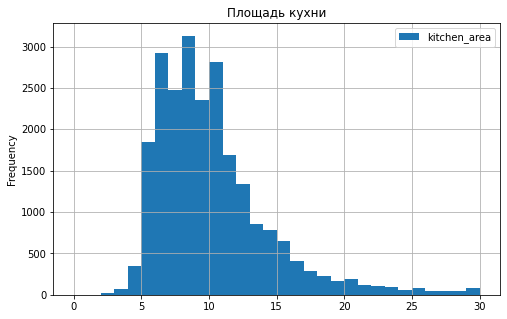

In [70]:
#изучим площадь кухни
df.plot(y='kitchen_area', kind='hist', bins=30, grid=True, figsize=(8,5), range=(0,30), title='Площадь кухни')
df['kitchen_area'].describe().to_frame()

Наиболее распространены кухни площадью от 5 до 15 метров. Кухни площадью более 20 метров практически не встречаются, а площадь кухни более 30 метров встречается крайне редко.

,last_price_m
count,23569.000
mean,6.284
std,7.729
min,0.012
25%,3.400
50%,4.600
75%,6.740
max,330.000


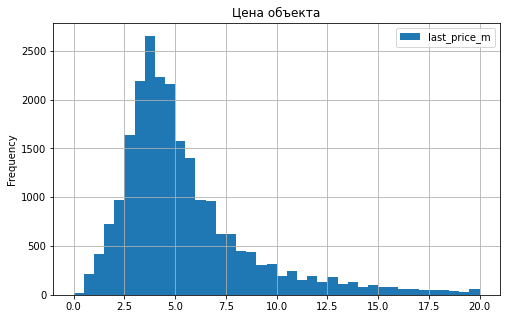

In [71]:
#построение гистограммы цен объектов 
df.plot(y='last_price_m', kind='hist', bins=40, grid=True, figsize=(8,5), range=(0,20), title='Цена объекта')
df['last_price_m'].describe().round(3).to_frame()

In [72]:
#удалим аномальные значения
df = df.query('last_price_m < 20')

В основном стоимость квартир - от 2 до 8 миллионов. Больше 15 миллионов вариантов мало. Но есть квартира за 763 миллиона - возможно, это частный дом, либо квартира в центре с очень большой площадью. Также есть квартира за 12 тысяч рублей - возможно, это очень маленький частный дом в области.


,rooms
count,22919.000000
mean,2.008770
std,0.982996
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,11.000000


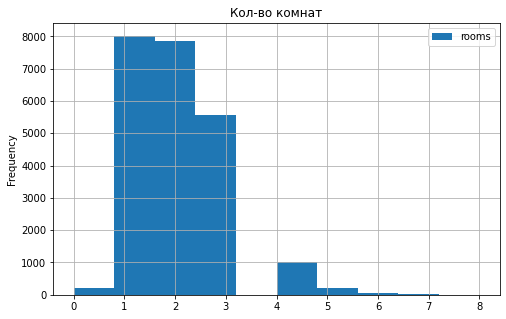

In [73]:
#изучим количество комнат
df.plot(y='rooms', kind='hist', bins=10, grid=True, figsize=(8,5), range=(0,8), title='Кол-во комнат')
df['rooms'].describe().to_frame()

В основном количество комнат от 1 до 4. Есть и вариант, где 11 комнат, возможно, это старый фонд и объединение нескольких квартир, либо же частные дома. Минимальное количество комнат - 0, возможно, это значение на сайте объявлений кто-то поставил при продаже квартиры-студии, так как это не отдельная комната, а целая квартира. 

In [74]:
#удалим аномальные значения
df = df.query('rooms < 7')

,ceiling_height
count,22890.000000
mean,2.709317
std,0.217441
min,1.000000
25%,2.580000
50%,2.699301
75%,2.724262
max,5.800000


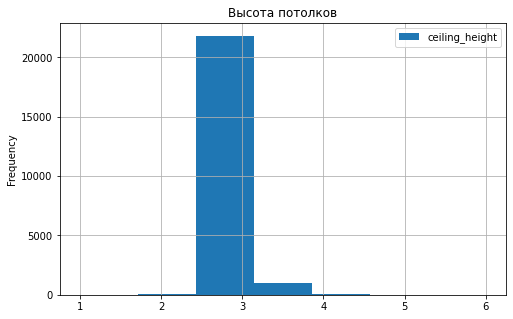

In [75]:
#изучим высоту потолков
df.plot(y='ceiling_height', kind='hist', bins=7, grid=True, figsize=(8,5), range=(1,6), title='Высота потолков')
df['ceiling_height'].describe().to_frame()

В основном квартиры имеют высоту потолков от 2,5 до 3,1 метров. Более высокие потолки могут быть в многоуровневых квартирах и в частных домах

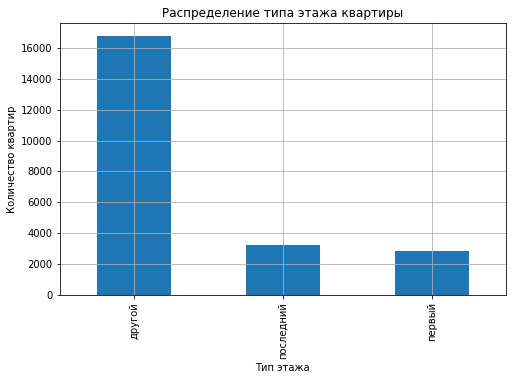

,floor_type
count,22890
unique,3
top,другой
freq,16763


In [76]:
#изучим тип этажа квартиры

# Создаем столбчатую диаграмму для типа этажа квартиры
df['floor_type'].value_counts().plot(kind='bar', grid=True, figsize=(8, 5))
plt.title('Распределение типа этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество квартир')
plt.show()

# Выводим описание типа этажа квартиры
df['floor_type'].describe().to_frame()

Первый и последний этаж встречаются реже, чем другой. 

,floors_total
count,22890.000000
mean,10.744954
std,6.633141
min,1.000000
25%,5.000000
50%,9.000000
75%,16.000000
max,60.000000


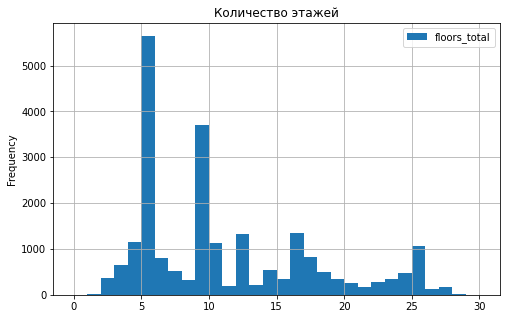

In [77]:
#изучим общее количество этажей в доме
df.plot(y='floors_total', kind='hist', bins=30, grid=True, figsize=(8,5), range=(0,30), title='Количество этажей')
df['floors_total'].describe().to_frame()

На графике есть несколько пиков - 6 и 9 этажные дома, что объяснимо исторической застройкой. Так же есть значительное количество 17-этажных и 26-этажных домов, типичных новостроек. Так же есть и 60 этажный дом, это вероятнее ошибка данных, либо квартира в Лахта-центре.  

,city_centers_nearest
count,17442.000000
mean,14516.728300
std,8573.402204
min,208.000000
25%,9856.250000
50%,13285.000000
75%,16465.000000
max,65968.000000


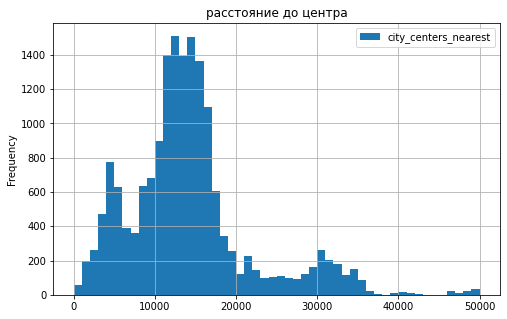

In [78]:
#изучим расстояние до центра города в метрах
df.plot(y='city_centers_nearest', kind='hist', bins=50, grid=True, figsize=(8,5), range=(0,50000), title='расстояние до центра')
df['city_centers_nearest'].describe().to_frame()

Наиболее распространены квартиры на окраинах Санкт-Петербурга - где большое количество новостроек. Так же есть большое количество квартир в центре.

,parks_nearest
count,7535.000000
mean,494.170007
std,342.390603
min,1.000000
25%,289.500000
50%,456.000000
75%,615.000000
max,3190.000000


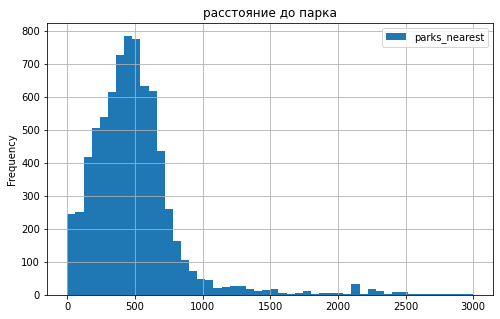

In [79]:
#изучим расстояние до ближайшего парка
df.plot(y='parks_nearest', kind='hist', bins=50, grid=True, figsize=(8,5), range=(0,3000), title='расстояние до парка')
df['parks_nearest'].describe().to_frame()

Квартиры, которые имеют парки рядом, в основном располагаются в 250-700 метров от них  

In [80]:
#посмотрим размер получившейся таблицы
new_df_count = df.shape[0]
#обратимся к переменной, созданной вначале, вычислим количество данных, которые отброшены
f"Количество отброшенных данных: {(100 - (new_df_count / initial_df_count * 100)):.2f}%"

'Количество отброшенных данных: 3.41%'

- Изучим, как быстро продавались квартиры (столбец days_exposition)

,days_exposition
count,19953.000000
mean,177.913396
std,216.526055
min,1.000000
25%,44.000000
50%,94.000000
75%,227.000000
max,1580.000000


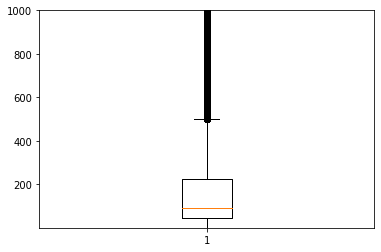

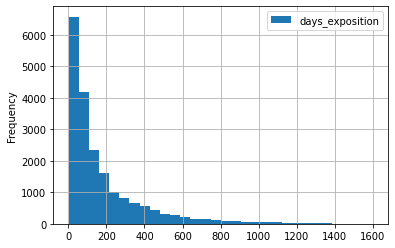

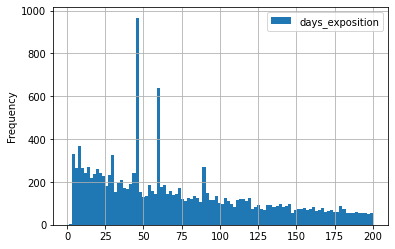

In [81]:
#диаграмма размаха
plt.boxplot(df[df['days_exposition']!=0]['days_exposition'])
plt.ylim(1,1000)

df.plot(y = 'days_exposition', kind = 'hist', bins = 30, grid = True, range = (1,1600))
df.plot(y = 'days_exposition', kind = 'hist', bins = 100, grid = True, range = (1,200))

#среднее значение, медиана и межквартильный размах
df[df['days_exposition']!=0]['days_exposition'].describe().to_frame()

In [82]:
df[df['days_exposition']!=0]['days_exposition'].value_counts()

45      879
60      535
7       233
30      205
4       175
       ... 
789       1
773       1
709       1
693       1
1391      1
Name: days_exposition, Length: 1123, dtype: Int64

Вывод: 
Среднее значение - 180 дней, а медиана - 95 дней. 
45, 60, 7, 30 - это наиболее популярное количество дней до снятия объявления. Возможно, после этого количества дней объявление требует повторного размещения на сайте

Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта.

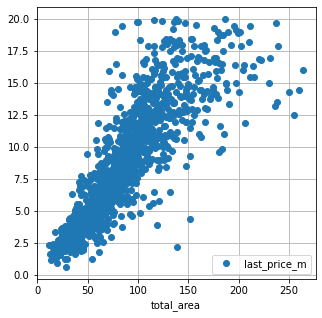

Корреляция цены и общей площади: 

              last_price_m  total_area
last_price_m      1.000000    0.891015
total_area        0.891015    1.000000 



In [83]:
#зависимость цены от общей площади
(
    df.pivot_table(index='total_area', values='last_price_m')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и общей площади:','\n')
print(df.pivot_table(index='floor', values=['total_area', 'last_price_m']).corr(),'\n')

Коэффициент корреляции составляет примерно 0.891, что указывает на то, что с увеличением общей площади квартиры цена квартиры также увеличивается, что мы видим и на графике

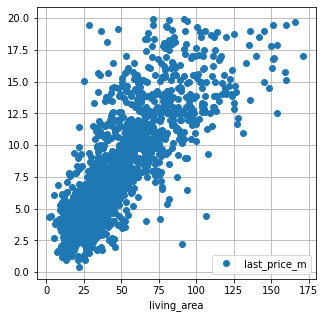

Корреляция цены и жилой площади: 

              last_price_m  living_area
last_price_m      1.000000     0.729781
living_area       0.729781     1.000000 



In [84]:
#зависимость цены от жилой площади
(
    df.pivot_table(index='living_area', values='last_price_m')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и жилой площади:','\n')
print(df.pivot_table(index='floor', values=['living_area', 'last_price_m']).corr(),'\n')

Существует умеренная положительная корреляция. Коэффициент корреляции составляет примерно 0.73, что указывает на среднюю положительную корреляцию между этими двумя переменными. С увеличением жилой площади недвижимости увеличивается и ее цена, но связь не так сильна, как в случае с общей площадью.

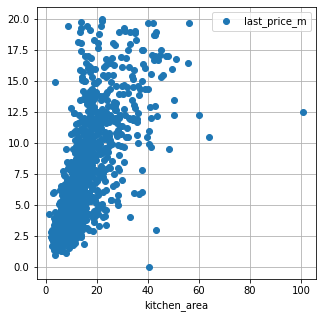

Корреляция цены и площади кухни: 

              kitchen_area  last_price_m
kitchen_area      1.000000      0.484605
last_price_m      0.484605      1.000000 



In [85]:
#зависимость цены от площади кухни
(
    df.pivot_table(index='kitchen_area', values='last_price_m')
    .plot(grid=True, style='o', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и площади кухни:','\n')
print(df.pivot_table(index='floor', values=['kitchen_area', 'last_price_m']).corr(),'\n')


Между ценой квартиры и площадью кухни существует слабая положительная корреляция. Коэффициент корреляции составляет примерно 0.48.

Это означает, что более высокие цены на квартиры могут коррелировать с большей площадью кухни, но связь между ними не такая сильная, как между ценой и общей или жилой площадью квартиры. Другие факторы также оказывают влияние на цену квартиры, помимо площади кухни.

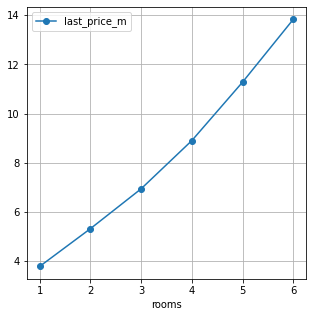

Корреляция цены и кол-ва комнат: 

              last_price_m     rooms
last_price_m      1.000000  0.567189
rooms             0.567189  1.000000 



In [86]:
#зависимость цены от кол-ва комнат
(
    df.query('rooms > 0').pivot_table(index='rooms', values='last_price_m')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()
print('Корреляция цены и кол-ва комнат:','\n')
print(df.query('rooms > 0').pivot_table(index='floor', values=['rooms', 'last_price_m']).corr(),'\n')


Чем больше комнат, тем выше цена, коэффициент корреляции 0.57, что указывает на умеренную положительную корреляцию 

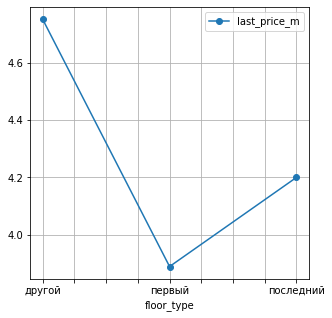

In [87]:
#зависимость цены от этажа
(
    df.pivot_table(index='floor_type', values='last_price_m', aggfunc='median')
    .plot(grid=True, style='o-', figsize=(5, 5))
)
plt.show()


Стомость квартиры на первом этаже ниже, но не сильно.

,mean,count,median
weekday,,,
1,5.461032,4060,4.65
2,5.471486,3838,4.60
0,5.366727,3476,4.55
3,5.464942,4118,4.50
4,5.354634,3882,4.50
5,5.230216,1875,4.50
6,5.224178,1641,4.50


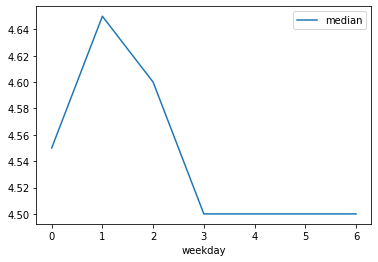

In [88]:
#зависимость цены от дня недели
pivot_table_weekday_exposition = df.pivot_table(index = 'weekday', values = 'last_price_m', aggfunc = ['mean', 'count', 'median'])
pivot_table_weekday_exposition.columns = ['mean', 'count', 'median']
pivot_table_weekday_exposition.plot(y = 'median')

pivot_table_weekday_exposition.sort_values('median', ascending = False)

Ближе к выходным цена ниже, чем на буднях. Возможно, это связано с тем, что обычно в выходные дни спрос на недвижимость может быть ниже из-за того, что люди заняты другими делами, такими как отдых с семьей или друзьями. Это может привести к увеличению предложения от продавцов, что, в свою очередь, может снизить цены.

,mean,count,median
month,,,
4,5.514717,2303,4.700
9,5.558902,1924,4.600
11,5.429926,2284,4.600
12,5.373733,1572,4.595
2,5.366498,2544,4.550
3,5.366478,2502,4.550
1,5.379703,1439,4.500
5,5.376841,1230,4.500
7,5.382317,1627,4.500


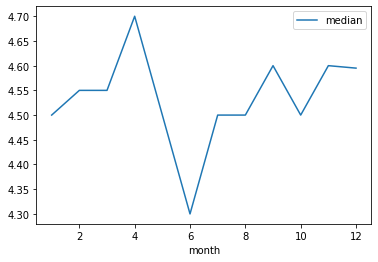

In [89]:
#зависимость цены от месяца
pivot_table_month_exposition = df.pivot_table(index = 'month', values = 'last_price_m', aggfunc = ['mean', 'count', 'median'])
pivot_table_month_exposition.columns = ['mean', 'count', 'median']
pivot_table_month_exposition.plot(y = 'median')

pivot_table_month_exposition.sort_values('median', ascending = False)

Наблюдаются сезонные колебания в ценах, с повышением к декабрю и, вероятно, снижением к весне и лету. Однако медианные значения остаются стабильными, что может свидетельствовать о стабильности рынка в целом. Апрель имеет наибольшее количество объявлений, что может указывать на более активный рынок или большее количество сделок в этот месяц. Июнь имеет наименьшее количество объявлений, что может быть связано с периодом отпусков.

,mean,count,median
year,,,
2014,8.038462,117,6.500
2015,6.132386,1118,5.115
2019,5.671674,2754,4.960
2018,5.260669,8307,4.500
2016,5.382922,2681,4.430
2017,5.301234,7913,4.400


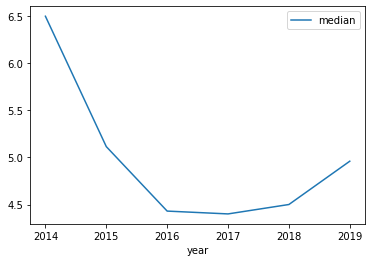

In [90]:
#зависимость цены от года
pivot_table_year_exposition = df.pivot_table(index = 'year', values = 'last_price_m', aggfunc = ['mean', 'count', 'median'])
pivot_table_year_exposition.columns = ['mean', 'count', 'median']
pivot_table_year_exposition.plot(y = 'median')

pivot_table_year_exposition.sort_values('median', ascending = False)

Цена снижается с 2014 года до 2017 года, после чего происходит её увеличение к 2018 году. Средняя цена была самой высокой в 2014 году и самой низкой в 2018 году. В 2014 году объявлений намного меньше, чем в другие годы. 

In [91]:
# Сравниваем среднюю стоимость квадратного метра в топ-10 городов по числу объявлений
top10 = df['locality_name'].value_counts().index.tolist()[:10]
mean10_metrics = [df[df['locality_name'] == city]['price_square_meter'].median().round(2) for city in top10]
mean10_count = [df[df['locality_name'] == city]['last_price'].count() for city in top10]
frame = {'Город': top10, 'Средняя цена за кв.м., тыс. руб.': mean10_metrics, 'Кол-во объявлений': mean10_count}
top10_price = pd.DataFrame(frame).sort_values(by='Средняя цена за кв.м., тыс. руб.', ascending=False)
top10_price                                                                          

,Город,"Средняя цена за кв.м., тыс. руб.",Кол-во объявлений
0,Санкт-Петербург,103448.28,14978
4,Пушкин,99678.55,360
8,деревня Кудрово,91860.47,299
6,посёлок Парголово,91780.22,326
1,посёлок Мурино,85878.46,556
2,посёлок Шушары,76876.18,440
5,Колпино,74722.22,337
7,Гатчина,67796.61,307
3,Всеволожск,65789.47,397
9,Выборг,58158.32,237


Самые дорогие стоимость квадратного метра в Санкт-Петербурге и в Пушкине. 
Чем дальше от города, тем дешевле. 
В Выборге средняя цена за квадратный метр в почти в 2 раза ниже, чем в Санкт-Петербурге.

Теперь выделим квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислим их среднюю стоимость на разном удалении от центра

In [92]:
df[df['locality_name'] == 'Санкт-Петербург']['city_centers_nearest_km'].isnull().sum()

0

,price_square_meter
city_centers_nearest_km,
0,118153.216429
1,129494.335779
2,122705.815675
3,113396.044953
4,120599.163576
5,125725.287487
6,127084.930815
7,123837.738432
8,121293.996137


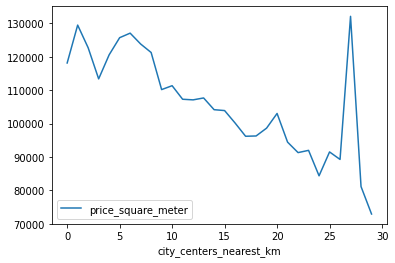

In [93]:
df['city_centers_nearest_km'] = np.floor(pd.to_numeric(df['city_centers_nearest_km'], errors='coerce')).astype('Int64')
pivot_table_km = df.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'city_centers_nearest_km', values = 'price_square_meter', aggfunc = 'mean')
pivot_table_km.plot()
pivot_table_km

По графику центр ограничен радиусом в 7-8 км, цены на 4-8 км сравнимы с ценами на квартиры, расположенные в 2 км от центра. Далее медианная цена довольно заметно падает. Также есть пик на 27 км от центра, возможно, это квартиры на южных окраинах города, но на берегу Финского залива, либо же в элитных районах. 

### Общий вывод

В ходе проекта была выполнена предобработка данных, включающая удаление или заполнение пропусков, обработку аномальных значений и удаление дубликатов. 

Также была выполнена категоризация некоторых данных для обеспечения их удобства в последующем анализе. 

В результате анализа были сделаны следующие выводы: 

Продажа квартиры в большинстве случаев занимает примерно 95 дней. Встречаются случаи, когда квартира продается всего за несколько дней после размещения объявления, а также случаи, когда продажа затягивается на более долгий срок. 

На цену квартиры больше всего влияет ее площадь, а не количество комнат или размер кухни. Таким образом, бывают случаи дорогих квартир с небольшим количеством комнат, но просторных.

Первый этаж квартиры дешевле по сравнению с другими этажами.

В топ-10 населенных пунктов самый дорогой квадратный метр находится в Санкт-Петербурге и составляет 104667 рублей, а самый дешевый - в Выборге, где он равен 58158 рублю.

Квартиры, выставленные на продажу в 2014 году, имеют самые высокие цены. В период с 2015 по 2018 год цены на квартиры оставались на низком уровне. В 2019 году цены начали расти. 
